# Convolutional Variational Autoencoder

## 1 Load Dataset

In [1]:
import tensorflow as tf

(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train.shape, x_test.shape

2025-05-14 06:54:33.141529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747198473.163757    6625 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747198473.171014    6625 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747198473.187091    6625 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747198473.187110    6625 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747198473.187112    6625 computation_placer.cc:177] computation placer alr

((60000, 28, 28), (10000, 28, 28))

## 2 Preprocessing

In [2]:
import numpy as np
import numpy.typing as npt


def preprocess_images(images: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
    """Reshape and normalize images.

    Parameters
    ----------
    images : npt.NDArray[np.float32]
        Images to be preprocessed.

    Returns
    -------
    npt.NDArray[np.float32]
        Preprocessed images.
    """

    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.0
    return np.where(images > 0.5, 1.0, 0.0).astype(np.float32)

x_train = preprocess_images(x_train)
x_test = preprocess_images(x_test)

In [3]:
batch_size = 32

ds_train = (
    tf.data.Dataset.from_tensor_slices(tensors=x_train)
    .shuffle(buffer_size=len(x_train))
    .batch(batch_size=batch_size)
)
ds_test = (
    tf.data.Dataset.from_tensor_slices(tensors=x_test)
    .shuffle(buffer_size=len(x_test))
    .batch(batch_size=batch_size)
)

I0000 00:00:1747198476.975803    6625 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3414 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1


## 3 Define Architecture

In [4]:
class CVAE(tf.keras.Model):
    """Conditional Variational Autoencoder (CVAE) class."""

    def __init__(self, latent_dim: int) -> None:
        """Instantiate the CVAE

        Parameters
        ----------
        latent_dim : int
            Size of the latent space.
        """
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(
                    filters=32,
                    kernel_size=3,
                    strides=2,
                    activation=tf.nn.relu,
                ),
                tf.keras.layers.Conv2D(
                    filters=64,
                    kernel_size=3,
                    strides=2,
                    activation=tf.nn.relu,
                ),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(units=latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7 * 7 * 32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64,
                    kernel_size=3,
                    strides=2,
                    padding="same",
                    activation=tf.nn.relu,
                ),
                tf.keras.layers.Conv2DTranspose(
                    filters=32,
                    kernel_size=3,
                    strides=2,
                    padding="same",
                    activation=tf.nn.relu,
                ),
                tf.keras.layers.Conv2DTranspose(
                    filters=1,
                    kernel_size=3,
                    strides=1,
                    padding="same",
                ),
            ]
        )

    @tf.function
    def sample(self, eps: tf.Tensor = None) -> tf.Tensor:
        """Sample with the decoder.

        Parameters
        ----------
        eps : tf.Tensor, optional
            Independently samples from standard normal distribution. If None, generate 100 samples.

        Returns
        -------
        tf.Tensor
            Generated sample images.
        """
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x: tf.Tensor) -> tuple[tf.Tensor, tf.Tensor]:
        """Encode the input images into a latent space.

        Parameters
        ----------
        x : tf.Tensor
            Input images.

        Returns
        -------
        tuple[tf.Tensor, tf.Tensor]
            Mean and log variance of the images in the latent space.
        """
        mean, logvar = tf.split(value=self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean: tf.Tensor, logvar: tf.Tensor) -> tf.Tensor:
        """Reparameterization 
        
        Get the input for the decoder.

        Parameters
        ----------
        mean : tf.Tensor
            Mean values of the input images in the latent space.
        logvar : tf.Tensor
            Log variance of the input images in the latent space.

        Returns
        -------
        tf.Tensor
            Input for the decoder.
        """
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean
    
    def decode(self, z: tf.Tensor, apply_sigmoid: bool = False):
        """Generate images from the latent space.

        Parameters
        ----------
        z : tf.Tensor
            Reparameterized embeddings of the images from latent space.
        apply_sigmoid : bool, optional
            If to apply sigmoid before output, by default False

        Returns
        -------
        tf.Tensor
            Generated images with the value for each pixel as logits or probabilities.
        """
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

## 4 Define Loss Function and Optimizer

In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)


def log_normal_pdf(
    sample: tf.Tensor, mean: tf.Tensor, logvar: tf.Tensor, raxis: int = 1
) -> tf.Tensor:
    """Log normal probability density function.

    Parameters
    ----------
    sample : tf.Tensor
        Data samples.
    mean : tf.Tensor
        Mean values of the input images in the latent space.
    logvar : tf.Tensor
        Log variance of the input images in the latent space.
    raxis : int, optional
        Axis to sum the log probabilities, by default 1 (for each sample).

    Returns
    -------
    tf.Tensor
        Log probabilities of the samples.
    """

    log2pi = tf.math.log(2.0 * np.pi)
    return tf.reduce_sum(
        input_tensor=-0.5
        * ((sample - mean) ** 2.0 * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis,
    )


def compute_loss(model: CVAE, x: tf.Tensor) -> tf.Tensor:
    """Compute the loss function.

    Parameters
    ----------
    model : CVAE
        Convolutional Variational Autoencoder model.
    x : tf.Tensor
        Input images.

    Returns
    -------
    tf.Tensor
        Loss value.
    """

    mean, logvar = model.encode(x=x)
    z = model.reparameterize(mean=mean, logvar=logvar)
    x_logit = model.decode(z=z)
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_logit)
    logp_x_z = -tf.reduce_sum(input_tensor=cross_entropy, axis=[1, 2, 3])
    logp_z = log_normal_pdf(z, 0., 0.)
    logq_z_x = log_normal_pdf(z, mean, logvar)

    return -tf.reduce_mean(logp_x_z + logp_z - logq_z_x)


@tf.function
def train_step(model: CVAE, x: tf.Tensor, optimizer: tf.keras.optimizers.Optimizer) -> None:
    """Train the model for one step.

    This function computes the loss and applies the gradients to the model's variables.

    Parameters
    ----------
    model : CVAE
        Convolutional Variational Autoencoder model.
    x : tf.Tensor
        Input images.
    optimizer : tf.keras.optimizers.Optimizer
        Optimizer to use for training.
    """

    with tf.GradientTape() as tape:
        loss = compute_loss(model=model, x=x)
    gradients = tape.gradient(target=loss, sources=model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## 5 Training

In [6]:
# Compile the model
epochs = 10
latent_dim = 2  # Set the dimensionality of the latent space to a plane for visualization
n_examples_to_generate = 25

random_vector_for_generation = tf.random.normal(
    shape=[n_examples_to_generate, latent_dim]
)
model = CVAE(latent_dim=latent_dim)
model.encoder.summary()
model.decoder.summary()

/home/yuncong-yu/projects/data-science/.venv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 13, 13, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 6, 6, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         9,220 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,036 (109.52 KB)

 Trainable params: 28,036 (109.52 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 1568)           │         4,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        18,496 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,953 (163.88 KB)

 Trainable params: 41,953 (163.88 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Generate images
import matplotlib.pyplot as plt

def generate_and_save_images(model: CVAE, epoch: int, test_samples: tf.Tensor) -> None:
    """Generate test images.

    Parameters
    ----------
    model : CVAE
        Convolutional Variational Autoencoder model.
    epoch : int
        Number of epochs.
    test_sample : tf.Tensor
        Test sample images.
    """

    mean, logvar = model.encode(x=test_samples)
    z = model.reparameterize(mean=mean, logvar=logvar)
    predictions = model.sample(eps=z)
    
    n_cols = 5
    n_rows = round(np.ceil(len(test_samples) / n_cols))
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(4, 4))

    for ax, image in zip(axs.ravel(), predictions):
        ax.imshow(image[:, :, 0], cmap="gray")
        ax.axis("off")

    fig.savefig(f"image_at_epoch_{epoch:04d}.png")
    fig.show()
    

In [8]:
# Pick a sample of the test set for generating output images
assert batch_size >= n_examples_to_generate
for test_batch in ds_test.take(1):
    test_samples = test_batch[:n_examples_to_generate]
test_samples

2025-05-14 06:54:38.386638: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<tf.Tensor: shape=(25, 28, 28, 1), dtype=float32, numpy=
array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
     

Epoch: 10, test set ELBO: -156.63330078125, time elapsed for each epoch: 8.731627464294434


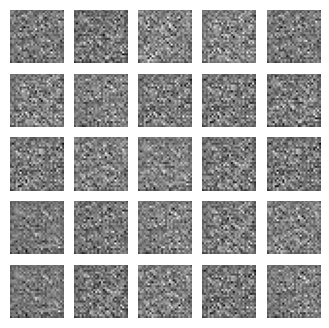

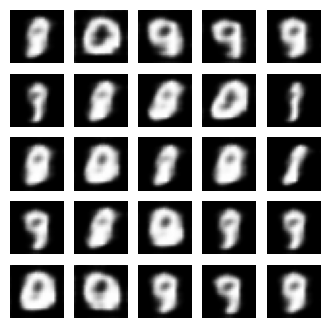

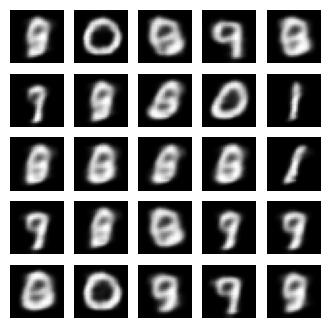

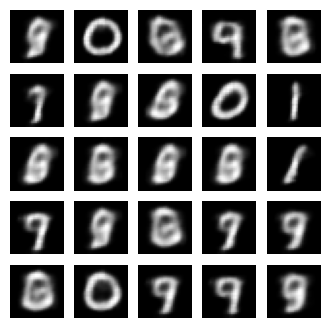

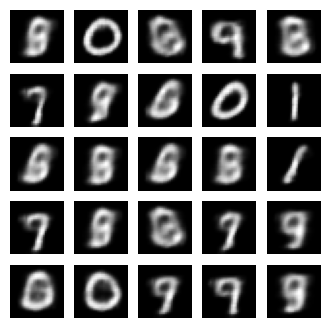

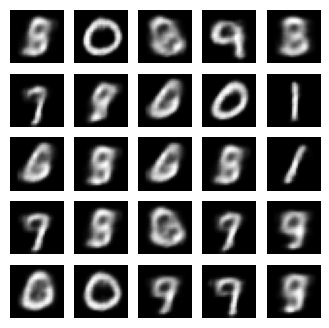

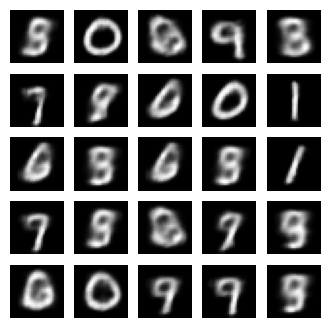

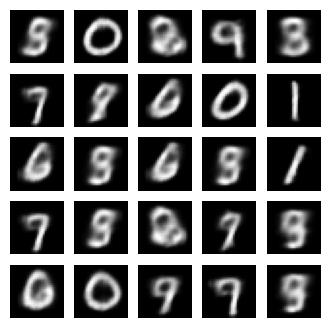

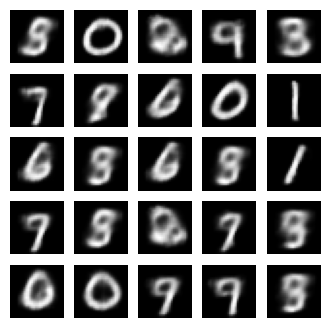

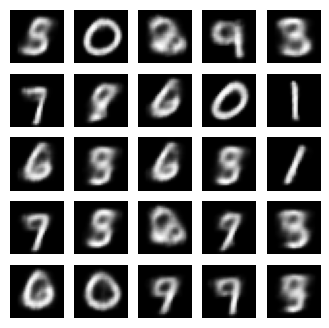

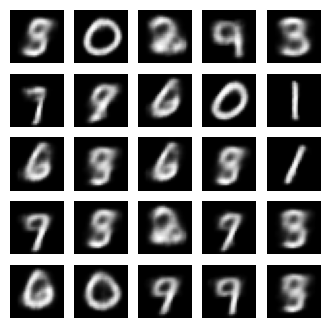

In [9]:
import IPython
import time

import IPython.display

# %matplotlib inline

generate_and_save_images(model=model, epoch=0, test_samples=test_samples)

for epoch in range(1, epochs + 1):
    t_start = time.time()
    for x_train in ds_train:
        train_step(model=model, x=x_train, optimizer=optimizer)
    t_end = time.time()

    loss = tf.keras.metrics.Mean()
    for x_test in ds_test:
        loss(compute_loss(model=model, x=x_test))
    elbo = -loss.result()

    IPython.display.clear_output(wait=False)
    print(f"Epoch: {epoch}, test set ELBO: {elbo}, time elapsed for each epoch: {t_end - t_start}")

    generate_and_save_images(model=model, epoch=epoch, test_samples=test_samples)

## 6 Result Visualization
Display a generated image from the last training epoch

(np.float64(-0.5), np.float64(399.5), np.float64(399.5), np.float64(-0.5))

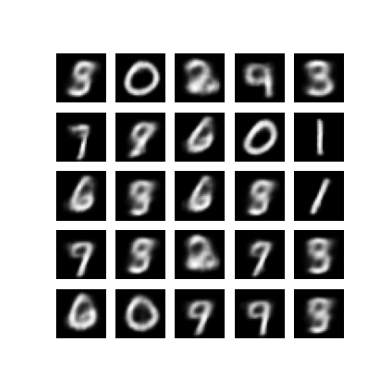

In [10]:
import PIL

def display_image(epoch_no: int) -> PIL.Image:
    """Display the generated image.

    Parameters
    ----------
    epoch_no : int
        The epoch number.

    Returns
    -------
    PIL.Image
        Generated image.
    """
    
    return PIL.Image.open(f"image_at_epoch_{epoch_no:04d}.png")

plt.imshow(display_image(epoch_no=epochs))
plt.axis("off")

Display an animated GIF of all the saved images

/tmp/ipykernel_6625/1522832746.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(path_file)
/tmp/ipykernel_6625/1522832746.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(path_file)



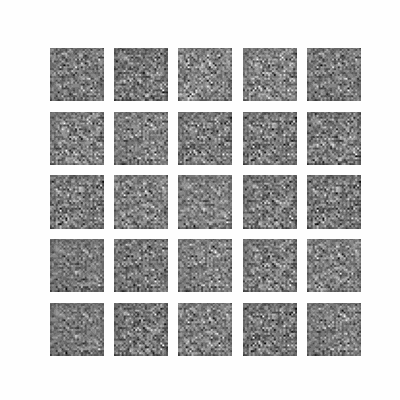

In [11]:
import pathlib
import imageio
import matplotlib
import tensorflow_docs.vis.embed as embed

matplotlib.use('TkAgg') 

path_animation = "cvae.gif"

with imageio.get_writer(uri=path_animation, mode="I") as writer:
    paths_files = sorted(pathlib.Path().glob("image*.png"))
    for path_file in paths_files:
        image = imageio.imread(path_file)
        writer.append_data(image)
    image = imageio.imread(path_file)
    writer.append_data(image)

embed.embed_file(path=path_animation)

Display a 2D manifold of digits from the latent space

/tmp/ipykernel_6625/1362042536.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


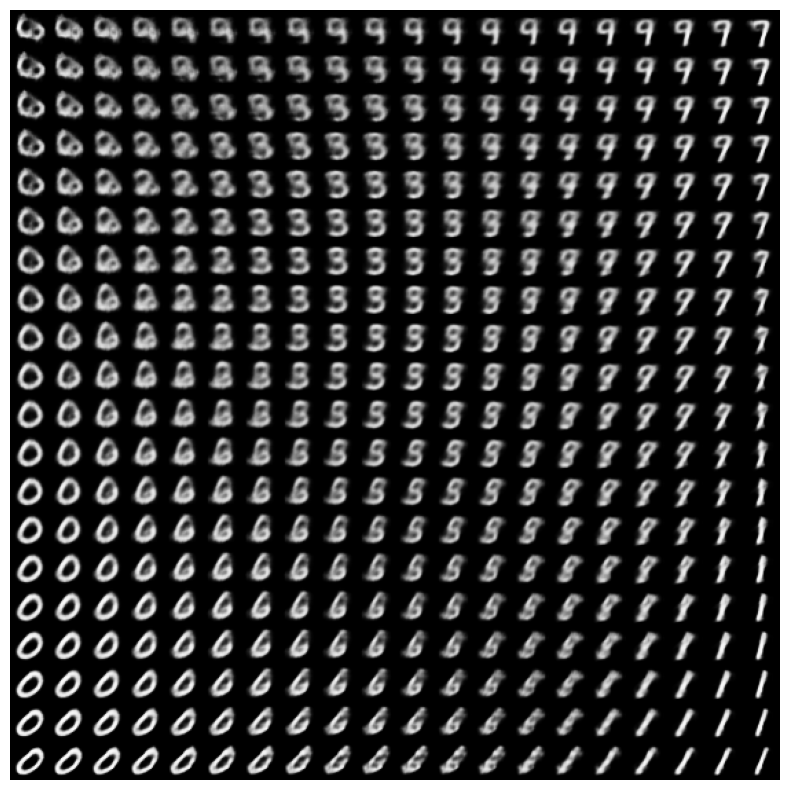

In [16]:
import tensorflow_probability as tfp

%matplotlib inline

def plot_latent_images(model: CVAE, n_rows: int, sub_image_size: int = 28):
    """Plot n x n digit images decoded from the latent space.

    Parameters
    ----------
    model : CVAE
        The trained convolutional variational autoencoder model.
    n_rows : int
        Number of sub-images each row (also each column) to plot.
    sub_image_size : int, optional
        The edge size of the sub-images in pixel, by default 28
    """

    norm_dist = tfp.distributions.Normal(loc=0, scale=1)
    grid_x = norm_dist.quantile(np.linspace(0.05, 0.95, n_rows))
    grid_y = norm_dist.quantile(np.linspace(0.05, 0.95, n_rows))
    image_width = sub_image_size * n_rows
    image_height = image_width
    image = np.zeros(shape=(image_height, image_width))

    for i_row, y in enumerate(grid_y):
        for i_col, x in enumerate(grid_x):
            z = np.array([[x, y]])
            x_decoded = model.sample(eps=z)
            digit = tf.reshape(x_decoded[0], (sub_image_size, sub_image_size))
            image[
                i_row * sub_image_size : (i_row + 1) * sub_image_size,
                i_col * sub_image_size : (i_col + 1) * sub_image_size,
            ] = digit.numpy()
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(X=image, cmap="Greys_r")
    ax.axis("off")
    fig.show()

plot_latent_images(model=model, n_rows=20)